# ****Import dependencies and load data****


In [1]:
import os
import numpy as np
import pandas as pd
import pickle
from tqdm import tqdm
from textwrap import wrap
import matplotlib.pyplot as plt


In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Dense, Embedding, Dropout, Reshape,
                                     Bidirectional, LSTM, Concatenate, Layer,
                                     GlobalAveragePooling2D)
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input as effnet_preprocess
from tensorflow.keras.regularizers import l2

2025-10-17 08:58:12.044752: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760691492.206439      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760691492.264087      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
data = pd.read_csv("/kaggle/input/flickr8k/captions.txt")
image_path = "/kaggle/input/flickr8k/Images"

In [4]:
def readImage(path, image_size=224):
    img = load_img(path, target_size=(image_size, image_size))
    img = img_to_array(img)
    img = effnet_preprocess(img)
    return img

In [5]:
def display_images(temp_df, image_path, image_size=224):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize=(15,15))
    n = 0
    for i in range(min(len(temp_df), 15)):
        n += 1
        plt.subplot(5,5,n)
        plt.subplots_adjust(hspace = 0.7, wspace= 0.3)
        image = readImage(os.path.join(image_path, temp_df['image'][i]), image_size=image_size)
        img_disp = (image - image.min()) / (image.max() - image.min())
        plt.imshow(img_disp.astype(np.float32))
        plt.title("\n".join(wrap(temp_df['caption'][i], 25)))
        plt.axis('off')
    plt.show()

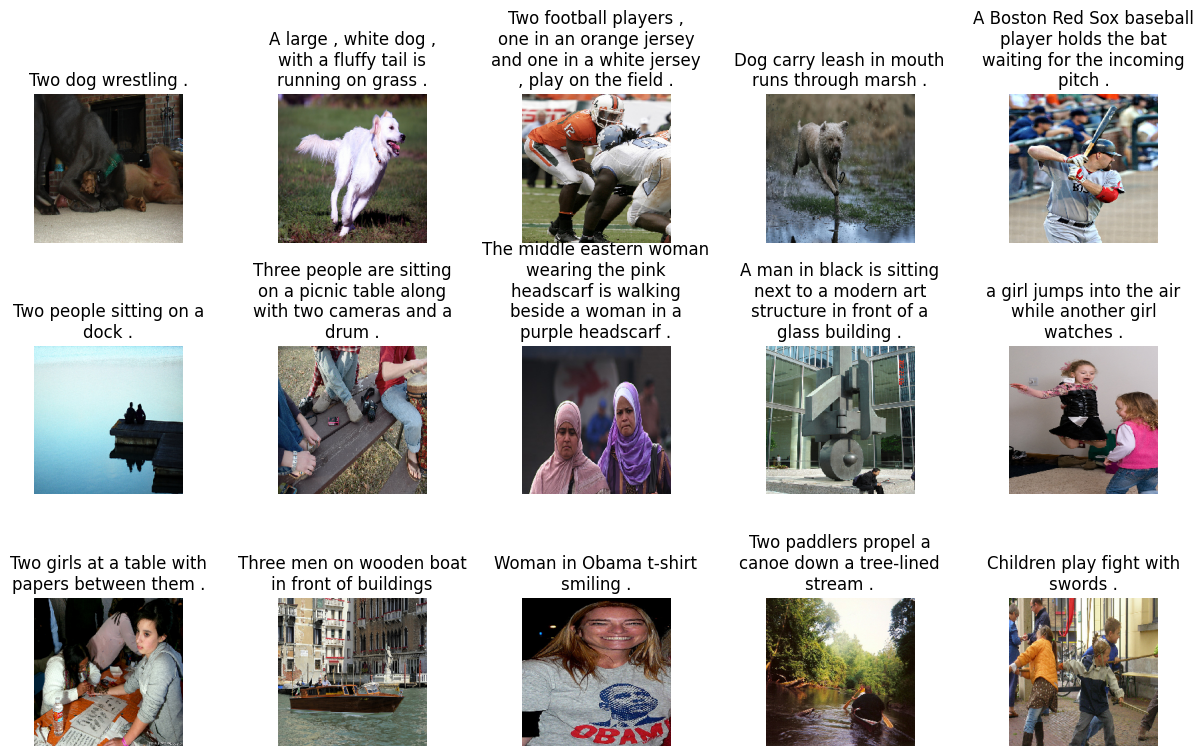

In [6]:
display_images(data.sample(15), image_path)

# ****Text Preprocessing****

In [7]:
import re
def text_preprocessing(df, caption_col='caption'):
    df[caption_col] = df[caption_col].astype(str).str.strip()
    df[caption_col] = df[caption_col].str.lower()
    df[caption_col] = df[caption_col].apply(lambda x: re.sub(r"[^a-z0-9\s\.,'!?-]", "", x))
    df[caption_col] = df[caption_col].apply(lambda x: "startseq " + x.strip() + " endseq")
    return df


In [8]:
data = text_preprocessing(data) 

In [9]:
data.head()

,image,caption
0,1000268201_693b08cb0e.jpg,startseq a child in a pink dress is climbing u...
1,1000268201_693b08cb0e.jpg,startseq a girl going into a wooden building ....
2,1000268201_693b08cb0e.jpg,startseq a little girl climbing into a wooden ...
3,1000268201_693b08cb0e.jpg,startseq a little girl climbing the stairs to ...
4,1000268201_693b08cb0e.jpg,startseq a little girl in a pink dress going i...


In [10]:
captions = data['caption'].tolist()

# ****Tokenization****

In [11]:
tokenizer = Tokenizer(oov_token=None)  
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
print(f"Vocab size: {vocab_size}")

Vocab size: 8496


In [12]:
max_length = max(len(c.split()) for c in captions)
print(f"Max caption length: {max_length}")

Max caption length: 40


In [13]:
images = data['image'].unique().tolist()
nimages = len(images)
print(f"Number of unique images: {nimages}")
split_index = round(nimages * 0.85)
train_images = images[:split_index]
val_images = images[split_index:]
train = data[data['image'].isin(train_images)].reset_index(drop=True)
val = data[data['image'].isin(val_images)].reset_index(drop=True)

Number of unique images: 8091


In [14]:
train

,image,caption
0,1000268201_693b08cb0e.jpg,startseq a child in a pink dress is climbing u...
1,1000268201_693b08cb0e.jpg,startseq a girl going into a wooden building ....
2,1000268201_693b08cb0e.jpg,startseq a little girl climbing into a wooden ...
3,1000268201_693b08cb0e.jpg,startseq a little girl climbing the stairs to ...
4,1000268201_693b08cb0e.jpg,startseq a little girl in a pink dress going i...
...,...,...
34380,3688839836_ba5e4c24fc.jpg,startseq a woman is holding out a peace sign d...
34381,3688839836_ba5e4c24fc.jpg,startseq a woman wearing a red scarf raises he...
34382,3688839836_ba5e4c24fc.jpg,startseq people in orange shirts marching down...
34383,3688839836_ba5e4c24fc.jpg,startseq the woman in the red shirt is holding...


In [15]:
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

# ****Image feature extraction****

In [16]:
img_size = 224

In [17]:
base_model = EfficientNetB0(weights='imagenet', include_top = False, input_shape = (img_size, img_size, 3))
fe_model = Model(inputs = base_model.input, outputs = base_model.output)

I0000 00:00:1760691524.932579      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [18]:
features = {}
for image in tqdm(data['image'].unique().tolist(), desc="Extracting features"):
    img = readImage(os.path.join(image_path, image), image_size=img_size)
    img = np.expand_dims(img, axis=0)
    feat_map = fe_model.predict(img, verbose=0)
    feat_map = feat_map[0]
    h, w, c = feat_map.shape
    feat_reshaped = feat_map.reshape(-1, c)
    features[image] = feat_reshaped.astype(np.float32)

Extracting features:   0%|          | 0/8091 [00:00<?, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1760691530.853822     101 service.cc:148] XLA service 0x7f596c001540 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1760691530.854412     101 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1760691531.548157     101 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1760691535.399195     101 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
Extracting features: 100%|██████████| 8091/8091 [11:55<00:00, 11.31it/s]


In [19]:
sample_feature = next(iter(features.values()))
num_patches, feat_dim = sample_feature.shape
print("num_patches:", num_patches, "feat_dim:", feat_dim)

num_patches: 49 feat_dim: 1280


In [20]:
with open("features_effnetb7.pkl", "wb") as f:
    pickle.dump(features, f)


In [21]:
with open("tokenizer.pkl", "rb") as f:
    tokenizer = pickle.load(f)

In [22]:
with open("features_effnetb7.pkl", "rb") as f:
    features = pickle.load(f)

# ****Data generation****

In [23]:
class CustomDataGenerator(Sequence):
    def __init__(self, df, X_col, y_col, batch_size, tokenizer, vocab_size, max_length, features_dict, shuffle=True):
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features_dict
        self.shuffle = shuffle
        self.n = len(self.df)
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    def __len__(self):
        return int(np.ceil(self.n / float(self.batch_size)))
    @property
    def num_batches(self):
        return self.__len__()
    def __getitem__(self, index):
        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size, :]
        X1, X2, y = self.__get_data(batch)
        return (X1, X2), y
    def __get_data(self, batch):
        X1, X2, y = [], [], []
        images = batch[self.X_col].unique().tolist()
        
        for _, row in batch.iterrows():
            image = row[self.X_col]
            caption = row[self.y_col]
            feature = self.features[image]   
            seq = self.tokenizer.texts_to_sequences([caption])[0]
            
            for i in range(1, len(seq)):
                in_seq, out_seq = seq[:i], seq[i]
                in_seq = pad_sequences([in_seq], maxlen=self.max_length, padding='post')[0]
                out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                X1.append(feature)   
                X2.append(in_seq)
                y.append(out_seq)
        
        X1 = np.array(X1)  
        X2 = np.array(X2)  
        y  = np.array(y)   
        return X1, X2, y

In [24]:
class BahdanauAttention(Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = Dense(units)   
        self.W2 = Dense(units) 
        self.V  = Dense(1)     

    def call(self, encoder_features, decoder_hidden):
        decoder_hidden_with_time_axis = tf.expand_dims(decoder_hidden, 1)
        score = tf.nn.tanh(self.W1(encoder_features) + self.W2(decoder_hidden_with_time_axis))
        attention_weights = tf.nn.softmax(self.V(score), axis=1)
        context_vector = attention_weights * encoder_features
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, tf.squeeze(attention_weights, -1)
        return context_vector, tf.squeeze(attention_weights, -1)

# ****Model Building****

In [25]:
num_patches = sample_feature.shape[0]  
feat_dim = sample_feature.shape[1] 

In [26]:

encoder_input = Input(shape=(num_patches, feat_dim), name='image_features')
decoder_input = Input(shape=(max_length,), name='decoder_input')

In [27]:
embedding_dim = 512
embed = Embedding(input_dim=vocab_size, output_dim=embedding_dim, mask_zero=True, name='embed')(decoder_input)

In [28]:
bi_lstm = Bidirectional(LSTM(512, return_sequences=False, return_state=False), name='bilstm')(embed)

In [29]:
attention_units = 512
attention = BahdanauAttention(attention_units)
context_vector, att_weights = attention(encoder_input, bi_lstm)

In [30]:
concat = Concatenate(axis=-1)([context_vector, bi_lstm])
x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(concat)
x = Dropout(0.6)(x)  
x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.4)(x)  
outputs = Dense(vocab_size, activation='softmax')(x)

In [31]:
caption_model = Model(inputs=[encoder_input, decoder_input], outputs=outputs)
caption_model.compile(loss='categorical_crossentropy', optimizer='adam')
caption_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ decoder_input       │ (None, 40)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embed (Embedding)   │ (None, 40, 512)   │  4,349,952 │ decoder_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 40)        │          0 │ decoder_input[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ image_features      │ (None, 49, 1280)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bilstm              │ (None, 1024)      │  4,198,400 │ embed[0][0],      │
│ (Bidirectional)     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bahdanau_attention  │ [(None, 1280),    │  1,181,185 │ image_features[0… │
│ (BahdanauAttention) │ (None, 49)]       │            │ bilstm[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 2304)      │          0 │ bahdanau_attenti… │
│ (Concatenate)       │                   │            │ bilstm[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 512)       │  1,180,160 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512)       │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │    131,328 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 8496)      │  2,183,472 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 13,224,497 (50.45 MB)

 Trainable params: 13,224,497 (50.45 MB)

 Non-trainable params: 0 (0.00 B)

In [32]:
batch_size = 32  
train_generator = CustomDataGenerator(df=train, X_col='image', y_col='caption', batch_size=batch_size,
                                      tokenizer=tokenizer, vocab_size=vocab_size, max_length=max_length,
                                      features_dict=features, shuffle=True)
validation_generator = CustomDataGenerator(df=val, X_col='image', y_col='caption', batch_size=batch_size,
                                           tokenizer=tokenizer, vocab_size=vocab_size, max_length=max_length,
                                           features_dict=features, shuffle=False)

In [33]:
model_name = "caption_trained_model.h5"
checkpoint = ModelCheckpoint(model_name, monitor="val_loss", mode="min", save_best_only=True, verbose=1)
earlystopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.2, min_lr=1e-9, verbose=1)

# ****Model Training****

In [34]:
history = caption_model.fit(
    train_generator,
    epochs=60,
    validation_data=validation_generator,
    callbacks=[checkpoint, earlystopping, reduce_lr],
    verbose=1
)

Epoch 1/60


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1075/1075 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 5.3504
Epoch 1: val_loss improved from inf to 3.81284, saving model to caption_trained_model.h5
1075/1075 ━━━━━━━━━━━━━━━━━━━━ 189s 169ms/step - loss: 5.3497 - val_loss: 3.8128 - learning_rate: 0.0010
Epoch 2/60
1075/1075 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 3.8291
Epoch 2: val_loss improved from 3.81284 to 3.57528, saving model to caption_trained_model.h5
1075/1075 ━━━━━━━━━━━━━━━━━━━━ 181s 168ms/step - loss: 3.8290 - val_loss: 3.5753 - learning_rate: 0.0010
Epoch 3/60
1075/1075 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 3.5916
Epoch 3: val_loss improved from 3.57528 to 3.48843, saving model to caption_trained_model.h5
1075/1075 ━━━━━━━━━━━━━━━━━━━━ 184s 171ms/step - loss: 3.5916 - val_loss: 3.4884 - learning_rate: 0.0010
Epoch 4/60
1075/1075 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 3.4389
Epoch 4: val_loss improved from 3.48843 to 3.44866, saving model to caption_trained_model.h5
1075/1075 ━━━━━━━━━━━━━━━━━━━━ 182s 169ms/st

# ****Learning curve****

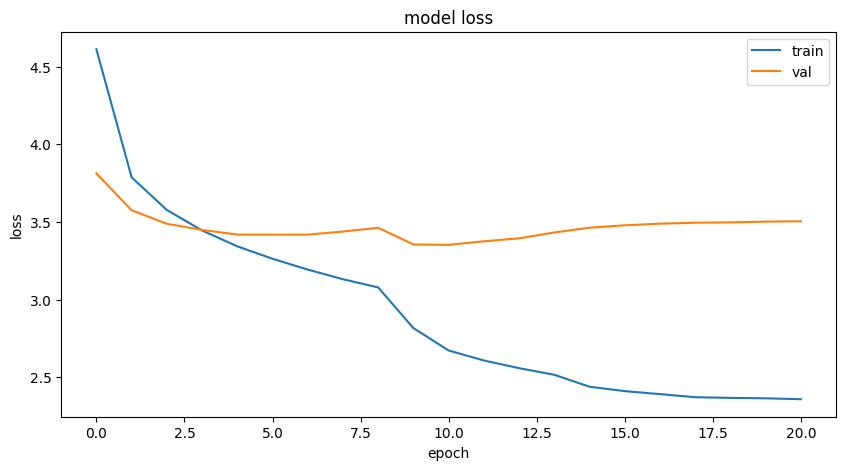

In [35]:
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()


# ****Inferencing****

In [36]:

def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [37]:
def clean_caption(raw_caption):
    caption = raw_caption.replace('startseq', '').replace('endseq', '').strip()
    caption = caption.capitalize()
    if not caption.endswith('.'):
        caption = caption + '.'
    return caption

In [38]:
import math
def beam_search_predictions(model, tokenizer, feature, max_length, beam_index=3):
    start_token = tokenizer.word_index.get('startseq')
    end_token = tokenizer.word_index.get('endseq')
    if start_token is None or end_token is None:
        raise ValueError("startseq/endseq tokens missing in tokenizer")
    sequences = [[ [start_token], 0.0 ]] 

    while True:
        all_candidates = []
        for seq, score in sequences:
            if seq[-1] == end_token or len(seq) >= max_length:
                all_candidates.append((seq, score))
                continue
            sequence = pad_sequences([seq], maxlen=max_length, padding='post')
            yhat = model.predict([feature[np.newaxis,...], sequence], verbose=0)[0] 
            top_indices = np.argsort(yhat)[-beam_index:]
            for idx in top_indices:
                prob = yhat[idx]
                if prob <= 0:
                    continue
                candidate_seq = seq + [int(idx)]
                candidate_score = score + math.log(prob + 1e-10)
                all_candidates.append((candidate_seq, candidate_score))
        ordered = sorted(all_candidates, key=lambda tup: tup[1], reverse=True)
        sequences = ordered[:beam_index]
        
        if any(s[-1] == end_token for s, _ in sequences):
            break
        
        if len(sequences[0][0]) >= max_length:
            break


    best_seq = sequences[0][0]
    
    words = [idx_to_word(i, tokenizer) for i in best_seq]

    caption = " ".join([w for w in words if w is not None])
    return clean_caption(caption)

def predict_caption_beam(model, image_key, tokenizer, max_length, features_dict, beam_index=3):
    feature = features_dict[image_key]
    return beam_search_predictions(model, tokenizer, feature, max_length, beam_index=beam_index)

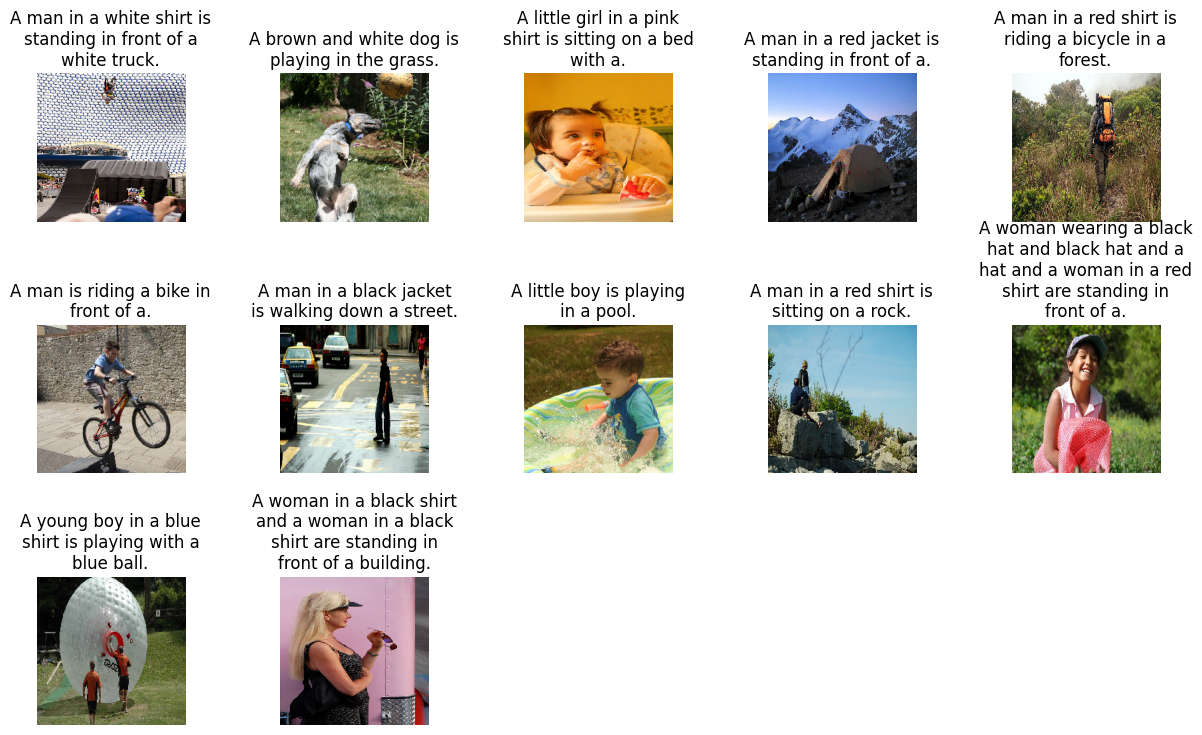

In [39]:
samples = val.sample(12).reset_index(drop=True)
for idx, row in samples.iterrows():
    pred = predict_caption_beam(caption_model, row['image'], tokenizer, max_length, features, beam_index=3)
    samples.at[idx, 'caption'] = pred

display_images(samples, image_path, image_size=img_size)

In [ ]:
import ipywidgets as widgets
from IPython.display import display
from PIL import Image
import io
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array

# --- 1. Define a Professional Style and Layout ---

# A container to give the app a "card" look with a shadow
app_container = widgets.Layout(
    width='700px',
    border='1px solid #e0e0e0',
    padding='15px',
    margin='0 auto',
    box_shadow='0 4px 8px 0 rgba(0,0,0,0.1)',
    border_radius='8px'
)

# Header style
title = widgets.HTML(
    value="<div style='text-align:center;'>"
          "<h1>🖼️ <b>AI Image Caption Generator</b></h1>"
          "<p style='color:#555; font-size:14px;'>Upload an image to see the magic of AI in action.</p>"
          "</div><hr>"
)

# --- 2. Create the UI Widgets with Enhanced Styling ---

# --- Left Column: Image Upload and Preview ---
image_placeholder = widgets.HTML(
    value="<div style='text-align:center; color:#888; padding:50px; border: 2px dashed #ccc; border-radius:8px;'>"
          "<i>Image preview will appear here.</i>"
          "</div>"
)
image_preview = widgets.Image(format='jpeg', width=300, layout=widgets.Layout(margin='0 auto'))
image_box = widgets.VBox([image_placeholder], layout=widgets.Layout(align_items='center', min_height='250px'))

uploader = widgets.FileUpload(
    accept='image/*',
    multiple=False,
    description='Select Image',
    button_style='info'
)

left_box = widgets.VBox([
    widgets.HTML("<h3><b>1. Upload Your Image</b></h3>"),
    uploader,
    image_box
], layout=widgets.Layout(width='50%', padding='10px'))

# --- Right Column: Caption Output and Action Button ---
run_button = widgets.Button(
    description='Generate Caption',
    button_style='success',
    icon='magic',
    disabled=True,
    tooltip='Upload an image first',
    layout=widgets.Layout(width='95%', margin='20px 0 0 0')
)

caption_output = widgets.HTML(
    value="<div style='text-align:center; padding: 20px; color:#555; background-color:#f9f9f9; border-radius:8px; min-height:100px;'>"
          "Your generated caption will appear here."
          "</div>"
)

status_label = widgets.Label(value="", layout=widgets.Layout(margin='10px 0 0 5px'))

right_box = widgets.VBox([
    widgets.HTML("<h3><b>2. Get Your Caption</b></h3>"),
    caption_output,
    run_button,
    status_label
], layout=widgets.Layout(width='50%', padding='10px'))

# Combine columns into the main app body
app_body = widgets.HBox([left_box, right_box])

# The final layout
app_layout = widgets.VBox([title, app_body], layout=app_container)

# --- 3. Define the Interaction Logic ---

def on_upload_change(change):
    """Handles the file upload event."""
    if not change.new: return
    
    # Get uploaded image content
    file_info = change.owner.value[0]
    uploaded_image_data = file_info['content']
    
    # Update the image preview and enable the button
    image_preview.value = uploaded_image_data
    image_box.children = [image_preview] # Replace placeholder with the image
    run_button.disabled = False
    run_button.tooltip = 'Click to generate caption'
    status_label.value = "Image loaded. Ready to generate! ✨"
    caption_output.value = "<div style='text-align:center; padding: 20px; color:#555; background-color:#f9f9f9; border-radius:8px; min-height:100px;'>Click the button to generate your caption.</div>"

def on_button_clicked(b):
    """Handles the button click event."""
    # Provide instant feedback that processing has started
    run_button.disabled = True
    run_button.description = 'Generating...'
    run_button.icon = 'spinner'
    status_label.value = "Processing image... ⏳"
    
    try:
        # Get image data from the preview widget
        uploaded_image_data = image_preview.value

        # Preprocess the image (same as your original code)
        img = Image.open(io.BytesIO(uploaded_image_data)).convert("RGB")
        img = img.resize((img_size, img_size))
        img_array = img_to_array(img)
        img_array = effnet_preprocess(img_array)
        img_array = np.expand_dims(img_array, axis=0)

        # Extract features and generate the caption
        feature_map = fe_model.predict(img_array, verbose=0)[0]
        h, w, c = feature_map.shape
        feature_reshaped = feature_map.reshape(-1, c).astype(np.float32)
        
        caption = beam_search_predictions(
            caption_model, tokenizer, feature_reshaped, max_length, beam_index=5
        )

        # Display the successful result
        caption_output.value = f"<div style='padding: 20px; color:#003366; background-color:#e7f3ff; border-radius:8px; min-height:100px; font-size:18px; text-align:center;'><b>{caption}</b></div>"
        status_label.value = "Caption generated successfully! ✅"

    except Exception as e:
        caption_output.value = f"<div style='padding: 20px; color:#a94442; background-color:#f2dede; border-radius:8px; min-height:100px;'><b>Error:</b> {e}</div>"
        status_label.value = "An error occurred. ❌"
    finally:
        # Reset the button to its original state
        run_button.disabled = False
        run_button.description = 'Generate Caption'
        run_button.icon = 'magic'

# --- 4. Link the Logic to the Widgets ---
uploader.observe(on_upload_change, names='value')
run_button.on_click(on_button_clicked)

# --- 5. Display the Final UI ---
display(app_layout)

In [44]:
import ipywidgets as widgets
from IPython.display import display, clear_output
from PIL import Image
import io
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array

title = widgets.HTML("<h2> <b>Image Captioning AI</b></h2><p>Upload an image to generate a caption.</p>")

image_preview = widgets.Image(
    value=b'',
    format='jpg',
    width=300,
    height=300,
    layout=widgets.Layout(border='2px solid #ccc', margin='0 0 10px 0')
)


uploader = widgets.FileUpload(
    accept='image/*',
    multiple=False,
    description='Upload Image'
)

run_button = widgets.Button(
    description='Generate Caption',
    button_style='success',
    icon='magic',
    disabled=True, 
    tooltip='Upload an image first'
)


caption_output = widgets.HTML(
    value="<p style='color:#777; font-style:italic;'>Your generated caption will appear here.</p>",
    layout=widgets.Layout(border='1px solid #ddd', padding='10px', min_height='80px')
)

status_label = widgets.Label(value="")



left_box = widgets.VBox([uploader, image_preview, run_button])


right_box = widgets.VBox([widgets.HTML("<h3><b>Generated Caption</b></h3>"), caption_output, status_label])


app_layout = widgets.VBox([title, widgets.HBox([left_box, right_box])])





def on_upload_change(change):
    if not change.new:
        return
    
  
    file_info = change.owner.value[0]
    uploaded_image_data = file_info['content']
    
   
    image_preview.value = uploaded_image_data
    
 
    run_button.disabled = False
    run_button.tooltip = 'Click to generate caption'
    caption_output.value = "<p style='color:#777; font-style:italic;'>Ready to generate. Click the button!</p>"



def on_button_clicked(b):
    status_label.value = "Generating... ⏳"
    run_button.disabled = True
    
    try:
 
        uploaded_image_data = image_preview.value

        
        img = Image.open(io.BytesIO(uploaded_image_data)).convert("RGB")
        img = img.resize((img_size, img_size))
        img_array = img_to_array(img)
        img_array = effnet_preprocess(img_array)
        img_array = np.expand_dims(img_array, axis=0)

     
        feature_map = fe_model.predict(img_array, verbose=0)[0]
        h, w, c = feature_map.shape
        feature_reshaped = feature_map.reshape(-1, c).astype(np.float32)

       
        caption = beam_search_predictions(
            caption_model, 
            tokenizer, 
            feature_reshaped, 
            max_length, 
            beam_index=5
        )

        
        caption_output.value = f"<p style='font-size:16px; color:#0057e7;'><b>{caption}</b></p>"

    except Exception as e:
        caption_output.value = f"<p style='color:red;'>An error occurred: {e}</p>"
    finally:
        status_label.value = "Done! ✨"
        run_button.disabled = False 


uploader.observe(on_upload_change, names='value')
run_button.on_click(on_button_clicked)



display(app_layout)